# Experiment tracking

**Author: @THEFFTKID**

In order to follow up the different experiments to improve the model performance, MLflow will be used.

In [23]:
cd ~/downloads/Pedro-Pineapple/forecasting

/home/aargaez/downloads/Pedro-Pineapple/forecasting


In [24]:
from mlflow import MlflowClient
import mlflow

In [25]:
client = MlflowClient(tracking_uri="http://127.0.0.1:8080")

In [26]:
experiment_description = (
    "Index - Stock forecasting project."
    "This experiment contains the models using AC2 policy."
)

experiment_tags = {
    "project_name": "Continous update policy",
    "mlflow.note.content": experiment_description,
}

produce_apples_experiment = client.create_experiment(name="A2C", tags=experiment_tags)

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import environments
import numpy as np
import dataclasses

from typing import Tuple, Union, List
from stable_baselines3 import A2C
from dataclasses import dataclass
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix
)
from json import dumps

In [28]:
# Use the fluent API to set the tracking uri and the active experiment.
mlflow.set_tracking_uri("http://127.0.0.1:8080")

# Sets the current active experiment to the "index_forecast" experiment and returns the experiment metadata.
apple_experiment = mlflow.set_experiment("index_forecast")

# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "first_model"

# Define an artifact path that the model will be saved to.
artifact_path = "a2c_index"

2023/11/19 22:56:07 INFO mlflow.tracking.fluent: Experiment with name 'index_forecast' does not exist. Creating a new experiment.


In [29]:
# Model parameters.
@dataclass
class ModelParameters:
    time_steps: int
    window_size: int
    data_path: str
    is_random_walk: bool = False


def flatten_dict(d, parent_key='', sep='_'):
    """
    Flatten a nested dictionary by combining keys with their parent keys.

    Parameters:
    - d (dict): The input dictionary.
    - parent_key (str): The parent key for recursion.
    - sep (str): The separator to use between parent and child keys.

    Returns:
    - dict: The flattened dictionary.
    """
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

def data_splitter(
    raw_data: pd.DataFrame,
    proportion: int = 0.7,
    init: Union[int, Tuple[int, int]] = None,
    end: Union[int, Tuple[int, int]] = None
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the raw time series data set.
    """
    if isinstance(init, int) and isinstance(end, int):
        train = raw_data.iloc[:init]
        test = raw_data.iloc[end:]
    
    if isinstance(init, tuple) and isinstance(end, tuple):
        train = raw_data.iloc[init[0]:init[1]]
        test = raw_data.iloc[end[0]:end[1]]
    
    if not init and not end:
        splitter = round(raw_data.shape[0] * proportion)
        train, test = raw_data.iloc[:splitter], raw_data.iloc[splitter:]

    return train, test

def create_labels(
    x: pd.Series,
    bins: List[float],
    labels: List[Union[str, float, int]]
) -> Tuple[pd.Series, pd.Series]:
    """
    Create the labels based on a given pd.Series.
    """
    # Relative differences.
    relative_diff = x.pct_change(periods=1).fillna(value=0)
    # Percentual.
    perc_relative_diff = relative_diff * 100
    # Cut labels.
    all_labels = pd.cut(
        x=perc_relative_diff,
        bins=bins,
        labels=labels,
        right=False
    )

    return all_labels, perc_relative_diff

def evaluation_metrics(
    y_true: pd.Series,
    y_pred: pd.Series,
    target_names: List[Union[int,str,float]]
) -> Union[str, dict]:
    """
    Creates the confusion matrix from Scikit-learn.
    """
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=target_names
    )
    disp.plot()
    plt.show()

    report = classification_report(
        y_true=y_true,
        y_pred=y_pred,
        target_names=target_names,
        output_dict=True
    )
    return report

In [30]:
def train_experiment(parameters: ModelParameters):
    """
    Wrapper function for MLflow model versioning
    """
    # Read data.
    data = pd.read_csv(filepath_or_buffer=parameters.data_path)
    # Cast columns.
    data.columns = data.columns.str.lower()

    # TODO: Add statistical bins.
    data['labels'], data['perc_relative_diff'] = create_labels(
        x=data['close'],
        bins=[-float('inf'), -0.1, 0.1, float('inf')],
        labels=[0, 1, 2]
    )
    
    # Split dataset into train and test.
    df_train, df_test = data_splitter(raw_data=data)

    # Create the environment.
    env = environments.Forecasting(
        df=df_train, window_size=parameters.window_size
    )

    # Train environment.
    model = A2C('MlpPolicy', env, verbose=1)
    # Learn.
    model.learn(total_timesteps=parameters.time_steps)

    # Initialize a new environment with test-set.
    env = environments.Forecasting(
        df=df_test, window_size=parameters.window_size
    )

    # Reset environment.
    observation, info = env.reset()

    while True: 
        observation = observation[np.newaxis, ...]
        action, states = model.predict(observation)
        observation, rewards, done, truncated, info = env.step(action)
        if done or truncated:
            print('info', info, '\n')
            break
    
    y_true = df_test['labels'].to_numpy()[parameters.window_size + 1:]
    y_pred = np.concatenate(env.actions_history)

    performance = evaluation_metrics(
        y_true=y_true,
        y_pred=y_pred,
        target_names=['down', 'no', 'up']
    )

    print(dumps(performance, indent=4))

    # Logging params and metrics to MLflow.
    metrics = flatten_dict(d=performance)

    # Log the parameters used for the model fit.
    mlflow.log_params(params=dataclasses.asdict(parameters))

    # Log the error metrics that were calculated during validation.
    mlflow.log_metrics(metrics=metrics)

    # for name, metric in performance.items():
    #     mlflow.log_metric(key=name, value=metric)

    # TODO: Log an instance of the trained model for later use.

In [34]:
test = {
    "down": {
        "precision": 0.5,
        "recall": 0.0625,
        "f1-score": 0.1111111111111111,
        "support": 240.0
    },
    "no": {
        "precision": 0.2222222222222222,
        "recall": 0.05,
        "f1-score": 0.0816326530612245,
        "support": 40.0
    },
    "up": {
        "precision": 0.4391304347826087,
        "recall": 0.9223744292237442,
        "f1-score": 0.5949926362297496,
        "support": 219.0
    },
    "accuracy": 0.43887775551102204,
    "macro avg": {
        "precision": 0.38711755233494366,
        "recall": 0.3449581430745814,
        "f1-score": 0.2625788001340284,
        "support": 499.0
    },
    "weighted avg": {
        "precision": 0.4510189461047699,
        "recall": 0.43887775551102204,
        "f1-score": 0.3211129461391399,
        "support": 499.0
    }
}

In [31]:
# Experiment parameters.
parameters = ModelParameters(
    time_steps=200,
    window_size=15,
    data_path='~/downloads/Pedro-Pineapple/data/SPY_20172023.csv'
)

In [32]:
# Define new experiment.
experiment_name = 'A2C'
experiment_id = mlflow.set_experiment(experiment_name=experiment_name)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
info {'total_reward': 925.6400451660161} 



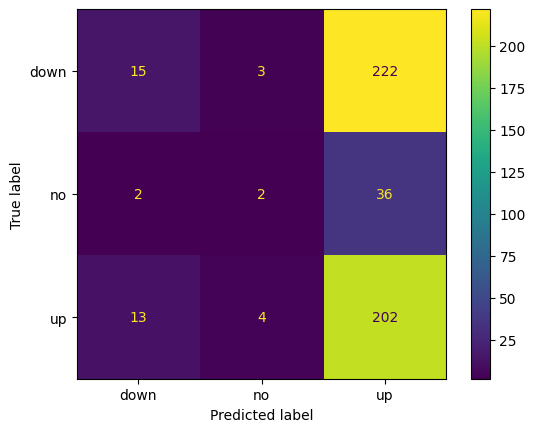

{
    "down": {
        "precision": 0.5,
        "recall": 0.0625,
        "f1-score": 0.1111111111111111,
        "support": 240.0
    },
    "no": {
        "precision": 0.2222222222222222,
        "recall": 0.05,
        "f1-score": 0.0816326530612245,
        "support": 40.0
    },
    "up": {
        "precision": 0.4391304347826087,
        "recall": 0.9223744292237442,
        "f1-score": 0.5949926362297496,
        "support": 219.0
    },
    "accuracy": 0.43887775551102204,
    "macro avg": {
        "precision": 0.38711755233494366,
        "recall": 0.3449581430745814,
        "f1-score": 0.2625788001340284,
        "support": 499.0
    },
    "weighted avg": {
        "precision": 0.4510189461047699,
        "recall": 0.43887775551102204,
        "f1-score": 0.3211129461391399,
        "support": 499.0
    }
}


In [33]:
# Run for save the model.
with mlflow.start_run(run_name=run_name) as run:
    train_experiment(parameters=parameters)